# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# !unzip "/content/drive/My Drive/Project_data.zip"

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/val.csv').readlines())
batch_size = 10 # experiment with the batch size

In [40]:
len(train_doc)

663

In [6]:
def cropResize(image, y, z):
    h, w = image.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [7]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [8]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def get_one_batch(source_path, folder_list, batch_size, img_idx, t, batch):
  # print("batch_size get_one_batch :",batch_size)
  x = len(img_idx)
  y = 120
  z = 120
  batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                # print(' Foder currently reading : ='+ source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                # print('IMGS...', imgs)

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # print('image index count : = ', idx , ' ; item =', item)
                    # print('Batch: = ', batch , ' ; Batch size: =', batch_size , ' ; index =' , batch*batch_size)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
def generator(source_path, folder_list, batch_size, img_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        # print("num_batches :",num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
          yield get_one_batch(source_path, folder_list, batch_size, img_idx, t, batch)
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            # batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            # for folder in range(batch_size): # iterate over the batch_size
            #     imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            #     for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            #         image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #         #crop the images and resize them. Note that the images are of 2 different shape
            #         #and the conv3D will throw error if the inputs in a batch have different shapes

            #         batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
            #         batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
            #         batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

            #     batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            # yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
          batch_size = len(folder_list)%batch_size
          yield get_one_batch(source_path, folder_list, batch_size, img_idx, t, batch)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition/Project_data/train'
val_path = '/kaggle/input/gesture-recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

#write your model here

In [13]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

print(make2dFilter(5))

(5, 5)


In [14]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [15]:
batch_size = 20
img_idx = [i for i in range(0,30,2)]
model = defineModel(img_idx)
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 11, 116, 116, 16)  6016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 58, 58, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 58, 58, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 56, 56, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 28, 28, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 28, 28, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 26, 26, 64)     5

In [16]:
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

if not os.path.exists(model_name):
    print("hey")
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

Current working directory: /kaggle/working
hey
model_init_2024-04-0313_39_29.843453/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
import matplotlib.pyplot as plt
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [20]:
def parameters():
  print(batch_size)
  print(num_epochs)
  print(img_idx)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## **Model 1**

In [ ]:
num_epochs = 20

In [ ]:
base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-36-bd12f99fffda>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,

<ipython-input-14-5214d24504d8>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20

34/34 [==============================] - ETA: 0s - loss: 1.7535 - categorical_accuracy: 0.2843

Epoch 1: saving model to model_init_2024-04-0104_47_36.951544/model-00001-1.75352-0.28431-6.12104-0.29000.h5

34/34 [==============================] - 32s 977ms/step - loss: 1.7535 - categorical_accuracy: 0.2843 - val_loss: 6.1210 - val_categorical_accuracy: 0.2900 - lr: 0.0010

Epoch 2/20

34/34 [==============================] - ETA: 0s - loss: 1.7432 - categorical_accuracy: 0.3725

Epoch 2: saving model to model_init_2024-04-0104_47_36.951544/model-00002-1.74316-0.37255-5.18712-0.39000.h5

34/34 [==============================] - 33s 991ms/step - loss: 1.7432 - categorical_accuracy: 0.3725 - val_loss: 5.1871 - val_categorical_accuracy: 0.3900 - lr: 0.0010

Epoch 3/20

34/34 [==============================] - ETA: 0s - loss: 1.7357 - categorical_accuracy: 0.2843

Epoch 3: saving model to model_init_2024-04-0104_47_36.951544/model-00003-1.73566-0.28431-4.28430-0.34000.h5

34/34 

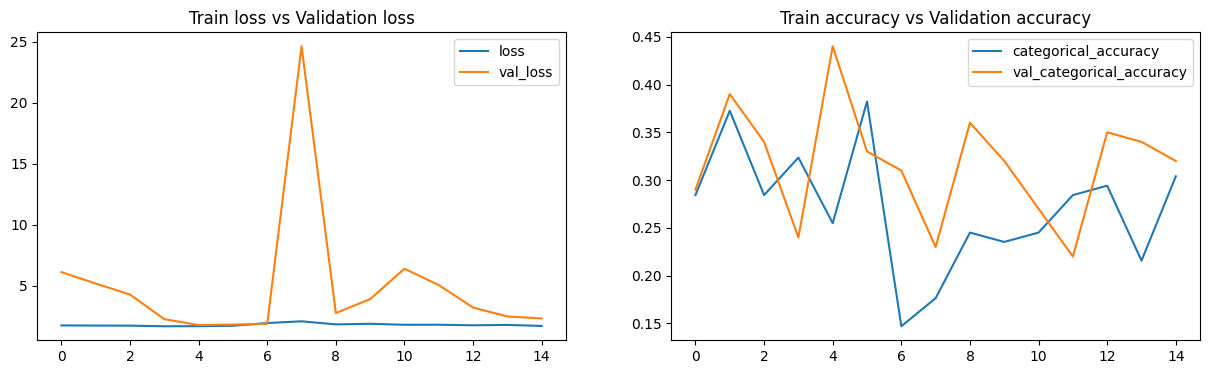

Max. Training Accuracy 0.38235294818878174

Max. Validaiton Accuracy 0.4399999976158142


In [ ]:
plotModelHistory(base_model_history)

We can see that our model early stop at 15 Epoch, but Max. Training Accuracy 0.38235294818878174 and Max. Validaiton Accuracy 0.4399999976158142 which is not good.

## **Model 2 - learning rate to 0.001 and increasing no of frames**

In [ ]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
batch_size = 20
img_idx = np.round(np.linspace(0, 29, 25)).astype(int)
model2 = defineModel(img_idx)
print (model2.summary())

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_3 (Conv3D)           (None, 21, 116, 116, 16   6016      

                             )                                   

                                                                 

 max_pooling3d_3 (MaxPoolin  (None, 11, 58, 58, 16)    0         

 g3D)                                                            

                                                                 

 batch_normalization_5 (Bat  (None, 11, 58, 58, 16)    64        

 chNormalization)                                                

                                                                 

 conv3d_4 (Conv3D)           (None, 9, 56, 56, 32)     13856     

                                                                 

 max_pooling3d_4 (MaxPoolin  (None, 9, 28, 28, 32)     0         

 g3D)                                 

In [ ]:
batch_size = 20
num_epochs = 10
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)
parameters()

20

10

[ 0  1  2  4  5  6  7  8 10 11 12 13 14 16 17 18 19 21 22 23 24 25 27 28

 29]


In [ ]:
model2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-26-0c2f24f00a43>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,

<ipython-input-12-5214d24504d8>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /content/Project_data/train ; batch size = 20

Epoch 1/10

34/34 [==============================] - ETA: 0s - loss: 1.5409 - categorical_accuracy: 0.4314Source path =  /content/Project_data/val ; batch size = 20



Epoch 1: saving model to model_init_2024-04-0107_06_12.398239/model-00001-1.54088-0.43137-11.19061-0.23000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


34/34 [==============================] - 177s 5s/step - loss: 1.5409 - categorical_accuracy: 0.4314 - val_loss: 11.1906 - val_categorical_accuracy: 0.2300 - lr: 0.0010

Epoch 2/10

34/34 [==============================] - ETA: 0s - loss: 1.8001 - categorical_accuracy: 0.3725

Epoch 2: saving model to model_init_2024-04-0107_06_12.398239/model-00002-1.80013-0.37255-21.04790-0.25000.h5

34/34 [==============================] - 45s 1s/step - loss: 1.8001 - categorical_accuracy: 0.3725 - val_loss: 21.0479 - val_categorical_accuracy: 0.2500 - lr: 0.0010

Epoch 3/10

34/34 [==============================] - ETA: 0s - loss: 1.9678 - categorical_accuracy: 0.3137

Epoch 3: saving model to model_init_2024-04-0107_06_12.398239/model-00003-1.96784-0.31373-10.08311-0.26000.h5

34/34 [==============================] - 46s 1s/step - loss: 1.9678 - categorical_accuracy: 0.3137 - val_loss: 10.0831 - val_categorical_accuracy: 0.2600 - lr: 0.0010

Epoch 4/10

34/34 [==============================] - ETA:

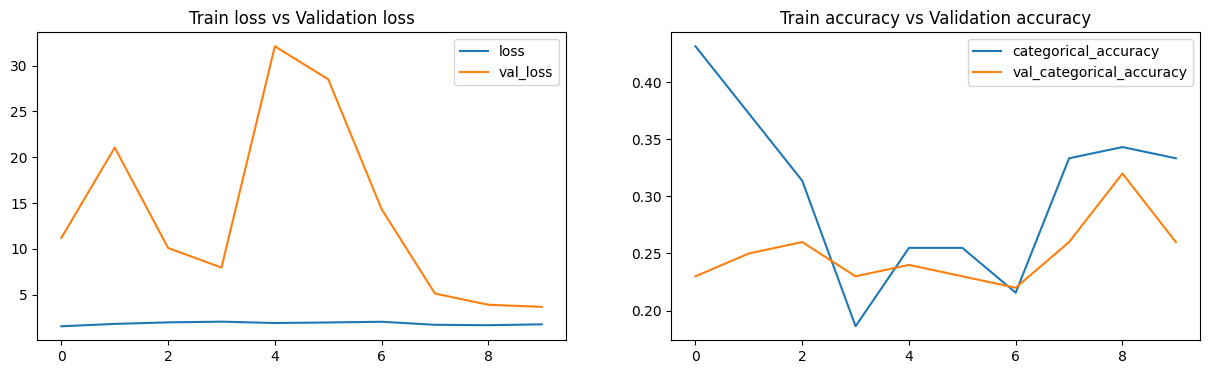

Max. Training Accuracy 0.4313725531101227

Max. Validaiton Accuracy 0.3199999928474426


In [ ]:
plotModelHistory(model2)

Training accuracy is impoved little bit

## **Model 3 - Frames 30, batch size = 64**

In [50]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
batch_size = 64
img_idx = np.round(np.linspace(0, 29, 30)).astype(int)
model3 = defineModel(img_idx)
print (model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 26, 116, 116, 16)  6016      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 13, 58, 58, 16)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 13, 58, 58, 16)    64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 11, 56, 56, 32)    13856     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 11, 28, 28, 32)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 11, 28, 28, 32)    128       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 9, 26, 26, 64)    

In [51]:
num_epochs = 15
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)
parameters()

64
15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [52]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_idx)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
(64, 30, 120, 120, 3)


In [53]:
print(steps_per_epoch)
print(num_train_sequences)
print(batch_size)
print(num_train_sequences%batch_size)

34
663
64
23


In [54]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    print(steps_per_epoch)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
    print(steps_per_epoch)

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
    print(validation_steps)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    print(validation_steps)

11
2


In [55]:
model3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - 243s 24s/step - loss: 1.8199 - categorical_accuracy: 0.3588 - val_loss: 5.2689 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2024-04-0111_33_06.024275/model-00001-1.53950-0.43439-5.26888-0.21000.h5
Epoch 2/15
11/11 [==============================] - 101s 10s/step - loss: 0.9866 - categorical_accuracy: 0.6211 - val_loss: 5.2492 - val_categorical_accuracy: 0.1562

Epoch 00002: saving model to model_init_2024-04-0111_33_06.024275/model-00002-1.01767-0.63636-5.24922-0.15625.h5
Epoch 3/15
11/11 [==============================] - 97s 10s/step - loss: 0.8980 - categorical_accuracy: 0.6660 - val_loss: 3.8351 - val_categorical_accuracy: 0.1786

Epoch 00003: saving model to model_init_2024-04-0111_33_06.024275/model-00003-0.94210-0.64427-3.83507-0.17857.h5
Epoch 4/15
11/11 [==============================] - 82s 8s/step - loss: 0.8

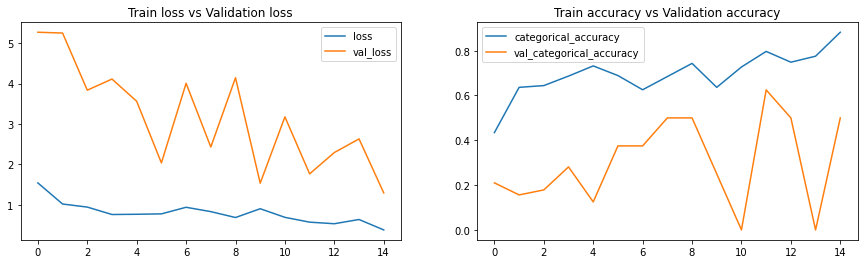

Max. Training Accuracy 0.8823529481887817
Max. Validaiton Accuracy 0.625


In [56]:
plotModelHistory(model3)

We can see that with Frames 30, batch size = 64, Max. Training Accuracy 0.8823529481887817 Max. Validaiton Accuracy 0.625 accuracy has improved. But model is overfitting.

# # **Model 4 - Reducing learning rate to 0.0001 and batch size to 32**

In [61]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
batch_size = 32
img_idx = np.round(np.linspace(0, 29, 30)).astype(int)
model4 = defineModel(img_idx)
print (model4.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 26, 116, 116, 16)  6016      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 13, 58, 58, 16)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 13, 58, 58, 16)    64        
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 11, 56, 56, 32)    13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 11, 28, 28, 32)    0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 11, 28, 28, 32)    128       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 9, 26, 26, 64)    

In [62]:
num_epochs = 15
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)
parameters()

32
15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [63]:
print(steps_per_epoch)
print(num_train_sequences)
print(batch_size)
print(num_train_sequences%batch_size)

11
663
32
23


In [64]:
model4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/15
11/11 [==============================] - 147s 14s/step - loss: 1.9031 - categorical_accuracy: 0.2986 - val_loss: 1.5380 - val_categorical_accuracy: 0.2656

Epoch 00001: saving model to model_init_2024-04-0111_33_06.024275/model-00001-1.70010-0.35795-1.53802-0.26562.h5
Epoch 2/15
11/11 [==============================] - 102s 10s/step - loss: 1.2354 - categorical_accuracy: 0.5489 - val_loss: 1.7537 - val_categorical_accuracy: 0.1250

Epoch 00002: saving model to model_init_2024-04-0111_33_06.024275/model-00002-1.23158-0.55988-1.75374-0.12500.h5
Epoch 3/15
11/11 [==============================] - 78s 7s/step - loss: 0.8244 - categorical_accuracy: 0.6911 - val_loss: 1.5568 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model_init_2024-04-0111_33_06.024275/model-00003-0.78641-0.68379-1.55683-0.37500.h5
Epoch 4/15
11/11 [==============================] - 82s 8s/step - loss: 0.63

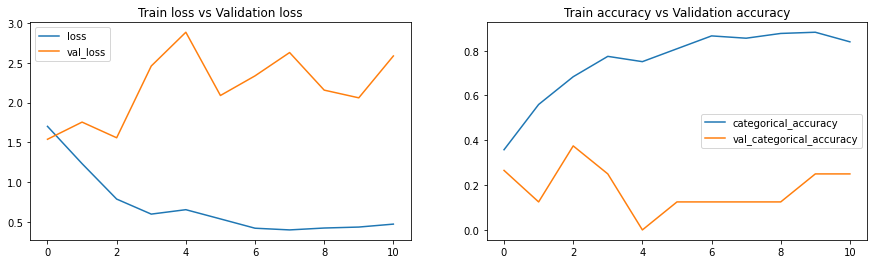

Max. Training Accuracy 0.8823529481887817
Max. Validaiton Accuracy 0.375


In [65]:
plotModelHistory(model4)

# # **Model5 Reducing only learning rate to 0.0001**

In [66]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
batch_size = 64
img_idx = np.round(np.linspace(0, 29, 30)).astype(int)
model5 = defineModel(img_idx)
print (model5.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 26, 116, 116, 16)  6016      
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 13, 58, 58, 16)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 13, 58, 58, 16)    64        
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 11, 56, 56, 32)    13856     
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 11, 28, 28, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 11, 28, 28, 32)    128       
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 9, 26, 26, 64)    

In [67]:
num_epochs = 15
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)
parameters()

64
15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [68]:
print(steps_per_epoch)
print(num_train_sequences)
print(batch_size)
print(num_train_sequences%batch_size)

11
663
64
23


In [69]:
model5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - 250s 25s/step - loss: 1.8358 - categorical_accuracy: 0.3438 - val_loss: 1.6572 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2024-04-0111_33_06.024275/model-00001-1.58982-0.42081-1.65721-0.29000.h5
Epoch 2/15
11/11 [==============================] - 99s 10s/step - loss: 0.8461 - categorical_accuracy: 0.7055 - val_loss: 1.7402 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model_init_2024-04-0111_33_06.024275/model-00002-0.86945-0.69565-1.74021-0.18750.h5
Epoch 3/15
11/11 [==============================] - 93s 9s/step - loss: 0.9595 - categorical_accuracy: 0.6238 - val_loss: 1.9434 - val_categorical_accuracy: 0.2321

Epoch 00003: saving model to model_init_2024-04-0111_33_06.024275/model-00003-0.92723-0.64822-1.94340-0.23214.h5
Epoch 4/15
11/11 [==============================] - 78s 8s/step - loss: 0.822

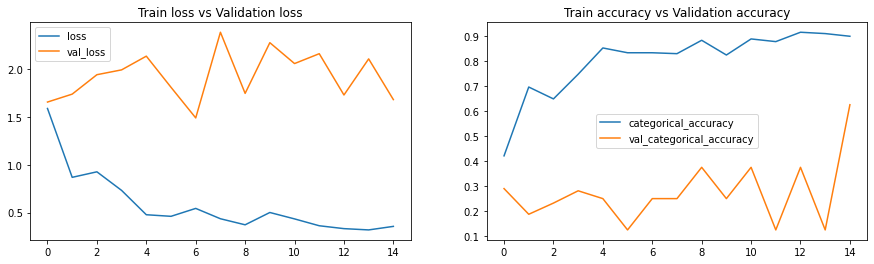

Max. Training Accuracy 0.9144384860992432
Max. Validaiton Accuracy 0.625


In [71]:
plotModelHistory(model5)

# # **Model 6 -  Increasing no of Epochs**

In [72]:
def defineModel(img_idx):
    inputShape = (len(img_idx), 120, 120, 3)

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
batch_size = 64
img_idx = np.round(np.linspace(0, 29, 30)).astype(int)
model6 = defineModel(img_idx)
print (model6.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 26, 116, 116, 16)  6016      
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 13, 58, 58, 16)    0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 13, 58, 58, 16)    64        
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 11, 56, 56, 32)    13856     
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 11, 28, 28, 32)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 11, 28, 28, 32)    128       
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 9, 26, 26, 64)    

In [73]:
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)
parameters()

64
30
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [74]:
print(steps_per_epoch)
print(num_train_sequences)
print(batch_size)
print(num_train_sequences%batch_size)

11
663
64
23


In [76]:
model6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - 107s 11s/step - loss: 1.0935 - categorical_accuracy: 0.5889 - val_loss: 20.6203 - val_categorical_accuracy: 0.1719

Epoch 00001: saving model to model_init_2024-04-0111_33_06.024275/model-00001-1.09346-0.58893-20.62027-0.17188.h5
Epoch 2/30
11/11 [==============================] - 86s 9s/step - loss: 0.9030 - categorical_accuracy: 0.6376 - val_loss: 10.4951 - val_categorical_accuracy: 0.2679

Epoch 00002: saving model to model_init_2024-04-0111_33_06.024275/model-00002-0.90298-0.63755-10.49515-0.26786.h5
Epoch 3/30
11/11 [==============================] - 72s 7s/step - loss: 0.9450 - categorical_accuracy: 0.6746 - val_loss: 11.6095 - val_categorical_accuracy: 0.3125

Epoch 00003: saving model to model_init_2024-04-0111_33_06.024275/model-00003-0.94503-0.67464-11.60952-0.31250.h5
Epoch 4/30
11/11 [==============================] - 75s 7s/step - loss: 0.9834 - categorical_accuracy: 0.6220 - val_loss: 3.6265 - val_categorical_accuracy: 0

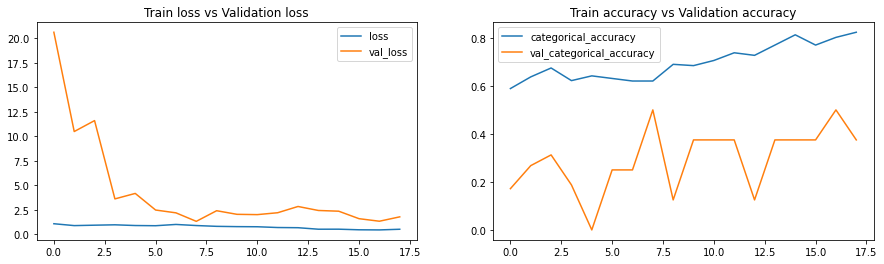

Max. Training Accuracy 0.8235294222831726
Max. Validaiton Accuracy 0.5


In [77]:
plotModelHistory(model6)

# # **Model 7 - Conv2D+LSTM**

In [103]:
n_frames = 30
num_epochs = 20
batch_size = 32

img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_idx), 120, 120, 3)

model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [104]:
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 30, 30, 64)   

In [105]:
model7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 258s 13s/step - loss: 1.4805 - categorical_accuracy: 0.3795 - val_loss: 1.6585 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2024-04-0115_25_43.707005/model-00001-1.32686-0.46305-1.65846-0.19000.h5
Epoch 2/20
21/21 [==============================] - 148s 7s/step - loss: 1.0466 - categorical_accuracy: 0.5743 - val_loss: 1.6994 - val_categorical_accuracy: 0.4375

Epoch 00002: saving model to model_init_2024-04-0115_25_43.707005/model-00002-1.05005-0.56936-1.69936-0.43750.h5
Epoch 3/20
21/21 [==============================] - 128s 6s/step - loss: 1.0183 - categorical_accuracy: 0.5633 - val_loss: 2.3004 - val_categorical_accuracy: 0.1250

Epoch 00003: saving model to model_init_2024-04-0115_25_43.707005/model-00003-0.99918-0.57143-2.30038-0.12500.h5
Epoch 4/20
21/21 [==============================] - 122s 6s/step - loss: 1.0

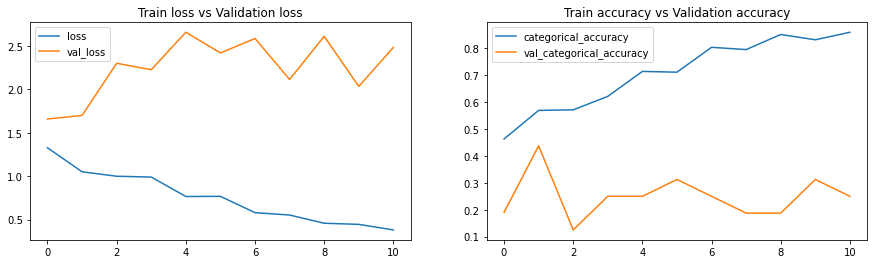

Max. Training Accuracy 0.8599439859390259
Max. Validaiton Accuracy 0.4375


In [106]:
plotModelHistory(model7)

In this model we can see that Training Accuracy is 0.86 model and Validaiton Accuracy is 0.4375 clearly model is overfitting

# # **Model 8 Conv2D + LSTM - increasing batch size**

In [107]:
n_frames = 30
num_epochs = 20
batch_size = 64

img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_idx), 120, 120, 3)

model8 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [108]:
model8.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 30, 30, 64)   

In [112]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
# earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [113]:
model8_hist = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
11/11 [==============================] - 62s 6s/step - loss: 0.6123 - categorical_accuracy: 0.7861 - val_loss: 1.5580 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2024-04-0115_25_43.707005/model-00001-0.61227-0.78610-1.55803-0.50000.h5
Epoch 2/20
11/11 [==============================] - 60s 6s/step - loss: 0.6518 - categorical_accuracy: 0.7594 - val_loss: 1.7824 - val_categorical_accuracy: 0.1250

Epoch 00002: saving model to model_init_2024-04-0115_25_43.707005/model-00002-0.65179-0.75936-1.78239-0.12500.h5
Epoch 3/20
11/11 [==============================] - 59s 6s/step - loss: 0.6187 - categorical_accuracy: 0.7914 - val_loss: 1.5779 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2024-04-0115_25_43.707005/model-00003-0.61868-0.79144-1.57792-0.25000.h5
Epoch 4/20
11/11 [==============================] - 57s 6s/step - loss: 0.6610 - categorical_accuracy: 0.7487 - val_loss: 2.0868 - val_categorical_accuracy: 0.1250

E

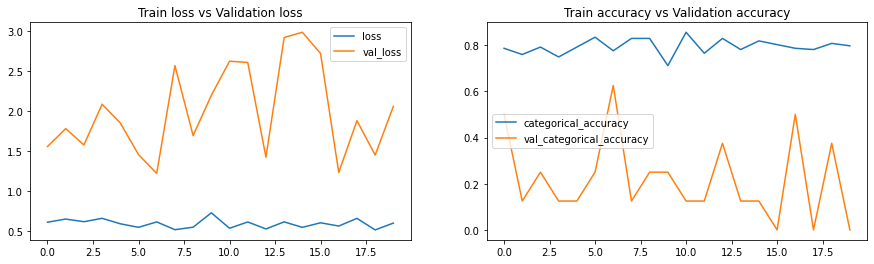

Max. Training Accuracy 0.855614960193634
Max. Validaiton Accuracy 0.625


In [114]:
plotModelHistory(model8_hist)

We can see with increase ib batch size to 32, validation accuracy has improved

# # **Model 9 Conv2D + LSTM - Increasing batch size to 64**

In [115]:
n_frames = 20
num_epochs = 30
batch_size = 64

img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_idx), 120, 120, 3)

model9 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [117]:
model9.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 64)   

In [118]:
model9_hist = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 157s 15s/step - loss: 1.5891 - categorical_accuracy: 0.2927 - val_loss: 1.6443 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2024-04-0115_25_43.707005/model-00001-1.44975-0.36350-1.64431-0.18000.h5
Epoch 2/30
11/11 [==============================] - 62s 6s/step - loss: 1.0260 - categorical_accuracy: 0.5818 - val_loss: 1.6246 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2024-04-0115_25_43.707005/model-00002-1.01556-0.57708-1.62462-0.25000.h5
Epoch 3/30
11/11 [==============================] - 57s 6s/step - loss: 1.2353 - categorical_accuracy: 0.4435 - val_loss: 1.7921 - val_categorical_accuracy: 0.2321

Epoch 00003: saving model to model_init_2024-04-0115_25_43.707005/model-00003-1.13850-0.47036-1.79211-0.23214.h5
Epoch 4/30
11/11 [==============================] - 48s 5s/step - loss: 1.0525

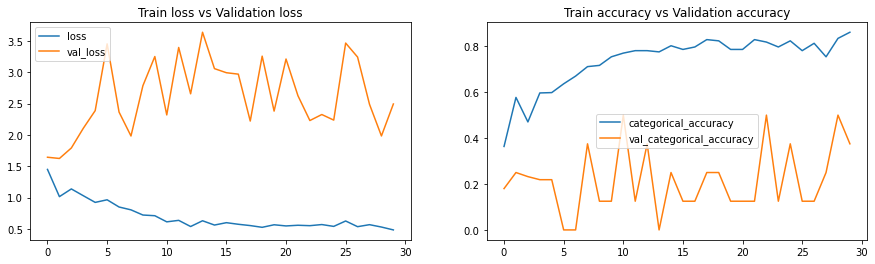

Max. Training Accuracy 0.8609625697135925
Max. Validaiton Accuracy 0.5


In [119]:
plotModelHistory(model9_hist)

# # **Model 10 Conv2D + LSTM - Increasing frame size to 30 - Final Model**

In [56]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
# earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [57]:
n_frames = 30
num_epochs = 30
batch_size = 64

img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_idx), 120, 120, 3)

model10 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [58]:
model10.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 30, 30, 64)   

In [59]:
model10_hist = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 299s 30s/step - loss: 1.5016 - categorical_accuracy: 0.3655 - val_loss: 1.6039 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2024-04-0216_31_38.342853/model-00001-1.42625-0.40422-1.60388-0.20000.h5
Epoch 2/30
11/11 [==============================] - 107s 11s/step - loss: 1.1715 - categorical_accuracy: 0.5157 - val_loss: 1.5685 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to model_init_2024-04-0216_31_38.342853/model-00002-1.14211-0.52569-1.56854-0.31250.h5
Epoch 3/30
11/11 [==============================] - 102s 10s/step - loss: 1.3226 - categorical_accuracy: 0.4616 - val_loss: 1.6671 - val_categorical_accuracy: 0.2321

Epoch 00003: saving model to model_init_2024-04-0216_31_38.342853/model-00003-1.31027-0.47036-1.66712-0.23214.h5
Epoch 4/30
11/11 [==============================] - 83s 8s/step - loss: 1.

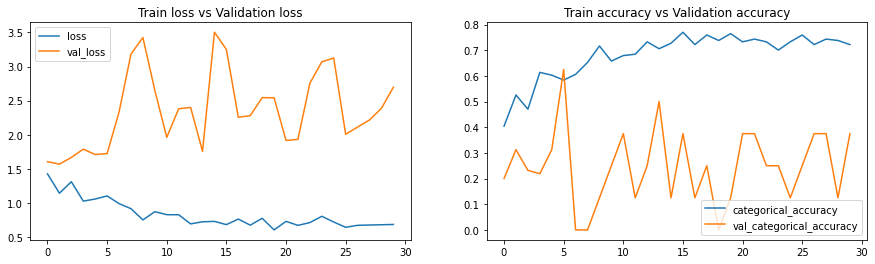

Max. Training Accuracy 0.7700534462928772
Max. Validaiton Accuracy 0.625


In [68]:
plotModelHistory(model10_hist)

With increase in frame size model is performing well

In [34]:
from tensorflow.keras.regularizers import l2

In [47]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

if not os.path.exists(model_name):
    print("hey")
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

Current working directory: /kaggle/working
model_init_2024-04-0313_39_29.843453/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


In [48]:

n_frames = 30
num_epochs = 30
batch_size = 64
l2_penalty=0.02

img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_idx), 120, 120, 3)

model11 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    TimeDistributed(Flatten()),
    LSTM(256, kernel_regularizer=l2(l2_penalty)),
    Dropout(0.2),

    Dense(256, activation='relu',kernel_regularizer=l2(l2_penalty)),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [49]:
model11.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model11.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_128 (TimeDi (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_130 (TimeDi (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_131 (TimeDi (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_132 (TimeDi (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_133 (TimeDi (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_134 (TimeDi (None, 30, 30, 30, 64)   

In [50]:
model11_hist = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 275s 27s/step - loss: 31.8107 - categorical_accuracy: 0.3365 - val_loss: 22.4289 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2024-04-0313_39_29.843453/model-00001-29.25696-0.40422-22.42891-0.28000.h5
Epoch 2/30
11/11 [==============================] - 104s 10s/step - loss: 19.5091 - categorical_accuracy: 0.5194 - val_loss: 14.3486 - val_categorical_accuracy: 0.1719

Epoch 00002: saving model to model_init_2024-04-0313_39_29.843453/model-00002-17.67172-0.51383-14.34860-0.17188.h5
Epoch 3/30
11/11 [==============================] - 91s 9s/step - loss: 12.1139 - categorical_accuracy: 0.4863 - val_loss: 9.7849 - val_categorical_accuracy: 0.2321

Epoch 00003: saving model to model_init_2024-04-0313_39_29.843453/model-00003-11.09875-0.51383-9.78495-0.23214.h5
Epoch 4/30
11/11 [==============================] - 75s 7s/step - 

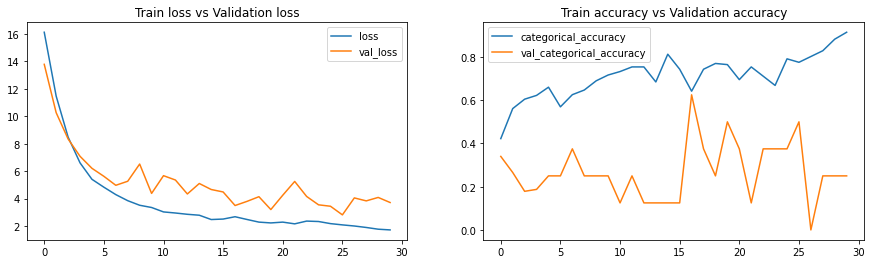

Max. Training Accuracy 0.9144384860992432
Max. Validaiton Accuracy 0.625


In [46]:
plotModelHistory(model11_hist)